## Quantum Natural Gradient Descent tutorial on a basic H2 VQE example from Yamamoto (2019)

A mini tutorial on using QNG to optimize a simple H2 VQE example in pennylane

In [3]:
!pip3 install pennylane

In [4]:
#import packages
import numpy as np
import pennylane as qml
from pennylane import expval, var
pi = np.pi

First thing we want to do is initialize our ansatz (because this is in fact how we derive our Fubini-Study metric)

The ansatz provided in Yamamoto (2019) is as follows: 

In [5]:
dev = qml.device("default.qubit", wires=2)

#create ansatz 
def ansatz(params, wires):
    
    #parameterized layer 0
    qml.RY(params[0], wires=0)
    qml.RY(params[1], wires=1)
    
    #entanglement
    qml.CNOT(wires=[0,1])
    
    #param layer 1
    qml.RY(params[2], wires=0)
    qml.RY(params[3], wires=1)


Next, we need to create our hamiltonian and cost function which we are trying to minimize. The hamiltonian used for H2 is:

$ H = \alpha (I \otimes \sigma _{z} + \sigma _{z} \otimes I) + \beta\sigma _{x} \otimes \sigma _{x}$

where $\alpha$ = 0.4 and $\beta$ = 0.2

In [ ]:
alpha = 0.4
beta = 0.2
coeffs = [alpha, alpha, beta]

#H2 hamiltonian from Yamamoto (2019)
obs_list = [
    qml.PauliZ(0) @ qml.Identity(1),
    qml.Identity(0) @ qml.PauliZ(1),
    qml.PauliX(0) @ qml.PauliX(1)
]

#create qnodes
qnodes = qml.map(ansatz, obs_list, dev, measure='expval')

#create cost function
cost = qml.dot(coeffs, qnodes)

In [9]:
params = np.random.rand(4)

In [ ]:
#alternate version
def circuit(params, obs):
    ansatz(params)
    return qml.expval(obs)

# Create a qnode for each operator in obs_list
qnodes = [qml.QNode(circuit, dev, obs=obs) for obs in obs_list]

# Now you can calculate the cost like this:
cost = 0
for coeff, qnode in zip(coeffs, qnodes):
    cost += coeff * qnode(params)


In this part, we actually start running our VQE with both the Quantum Natural Gradient Descent (QNG), the QNG diagnoal approxiamtion, and the vanilla gradient descent to compare their efficiencies.

We want to keep minimizing the energy until we reach a covergence tolerance of 1e-06.

Instead of using the pennylane functions qml.GradientDescentOptimizer and qml.QNGOptimizer, we are going to manually perform the descent because (as of right now) we can't compute it with a collection of QNodes; we are restricted to encoding it into a singular QNode. 

To compute the QNG Descent, we use:

$\theta_{n+1} = \theta_n - \eta F^{-1}\nabla \mathcal{L}(\theta) $

where $\theta_{n+1}$ is our updated parameter, $\theta$ is our current parameter, $\eta$ is our step size, $F$ is the computed Fubini-Study Metric (which is computed with qml.metric_tensor() from pennylane) and $\nabla \mathcal{L}(\theta)$ is the gradient of that parameter with respect to the cost function.

We iterate through this loop until we reach the covergance tolerance of 1e-06 (ie our ground state energy)

Similarly, to preform the vanilla gradient descent, we use:

$\theta_{n+1} = \theta_n - \eta \nabla \mathcal{L}(\theta) $

Which is almost identical to the Quantum Natural Gradient Descent, but it uses a Euclidean metric in the parameter space instead of the Fubini-Study metric in the quantum distribution space to update the parameters.

Finally, we also compute the QNG descent a second time, but with a diagonal approximation. This computes similarly to the regular QNG, but only uses the diagonal terms in the Fubini-Study Metric.

In [ ]:
#initialize constants
max_iterations = 500
step_size = 0.05
conv_tol = 1e-06

optimizers = ['QNG', 'Vanilla', 'QNG_diag']
QNG_cost = []
vanilla_cost = []
QNG_diag_cost = []

params = np.array([-0.2,-0.2,0,0])
prev_energy = cost(params)
for k in range(len(optimizers)):
    #Quantum Natural Gradient Descent
    if optimizers[k] == 'QNG':
        print("QUANTUM NATURAL GRADIENT")
        
        #initial params (example from Yamamoto 2019, FIG 5)
        params = np.array([-0.2,-0.2,0,0])
        
        for n in range(max_iterations):
            #compute the gradient
            gradient = qml.grad(cost, argnum=[0])
            
            #take the gradient of the params
            grad_at_point = [float(i) for i in gradient(params)[0]]
            
            #perform quantum natural gradient.
            params = params - step_size * np.dot(
                np.linalg.pinv(qnodes[0].metric_tensor([params])), 
                grad_at_point)
            
            #compute new energy with updates params
            energy = cost(params)
            QNG_cost.append(energy)
            
            #calculate convergence
            conv = np.abs(energy - prev_energy)

            if conv <= conv_tol:
                print('found ground-state at step {:}'.format(n))
                print("Groud-state energy = ", energy)
                break

            prev_energy = energy
            
    #Vanilla Gradient Descent
    if optimizers[k] == 'Vanilla':
        print("\nVANILLA GRADIENT")
        params = np.array([-0.2,-0.2,0,0])
        #params = np.array([(7*pi)/32,pi/2,0,0])
        for n in range(max_iterations):
            
            gradient = qml.grad(cost, argnum=[0])
            grad_at_point = [float(i) for i in gradient(params)[0]]
            
            #calculate vanilla gradient descent
            params = params - np.dot(step_size, grad_at_point)
            
            #calculate new energy with updates params
            energy = cost(params)
            vanilla_cost.append(energy)
            
            #calculate convergence
            conv = np.abs(energy - prev_energy)

            if conv <= conv_tol:
                print('found ground-state at step {:}'.format(n))
                print("Groud-state energy = ", energy)
                break

            prev_energy = energy
            
    #QNG Diagonal Approx. Descent
    if optimizers[k] == 'QNG_diag':
        print("\nQUANTUM NATURAL GRADIENT -- DIAGONAL")
        
        #initial params (example from Yamamoto 2019, FIG 5)
        params = np.array([-0.2,-0.2,0,0])
        #params = np.array([(7*pi)/32,pi/2,0,0])
        
        for n in range(max_iterations):
            #compute the gradient
            gradient = qml.grad(cost, argnum=[0])
            
            #take the gradient of the params
            grad_at_point = [float(i) for i in gradient(params)[0]]
            
            #perform quantum natural gradient.
            params = params - step_size * np.dot(
                np.linalg.pinv(qnodes[0].metric_tensor([params], diag_approx=True)), 
                grad_at_point)
            
            #compute new energy with updates params
            energy = cost(params)
            QNG_diag_cost.append(energy)
            
            #calculate convergence
            conv = np.abs(energy - prev_energy)


            if conv <= conv_tol:
                print('found ground-state at step {:}'.format(n))
                print("Groud-state energy = ", energy)
                break

            prev_energy = energy


QUANTUM NATURAL GRADIENT
found ground-state at step 56
Groud-state energy =  -0.8246156406856626

VANILLA GRADIENT
found ground-state at step 350
Groud-state energy =  -0.8245739903116748

QUANTUM NATURAL GRADIENT -- DIAGONAL
found ground-state at step 101
Groud-state energy =  -0.8246101191465934


All that's left is to plot our results!
As expected, the QNG out-performs the vanilla gradient descent by a long shot. The QNG finds the groud state at about step 56, the vanilla gradient descent found it at step 350, and the QNG with the diagonal approximation found it at step 101. This further proves that optimization in the distribution space is much more efficient than in the parameter space.

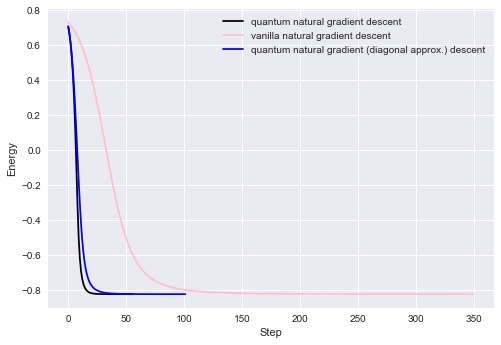

In [ ]:
from matplotlib import pyplot as plt
plt.style.use("seaborn")
plt.plot(QNG_cost, "black", label="quantum natural gradient descent")
plt.plot(vanilla_cost, "pink", label="vanilla natural gradient descent")
plt.plot(QNG_diag_cost, "b", label="quantum natural gradient (diagonal approx.) descent")

plt.ylabel("Energy")
plt.xlabel("Step")
plt.legend()
plt.show()